In [1]:
import torch
import numpy as np

from torch import optim, nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from tqdm import  notebook
from scipy import stats

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
print(device)

cuda:0


In [4]:
#### load data

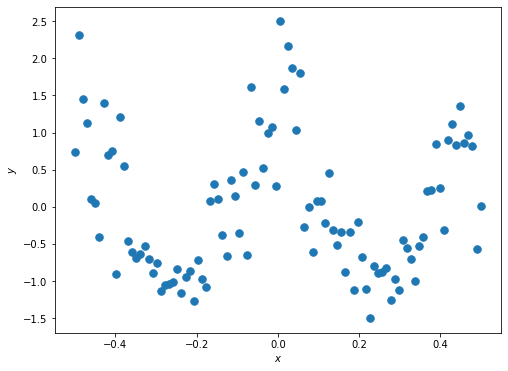

In [5]:
from scipy.stats import norm
def gen3(x,q):
  z=torch.from_numpy(norm.ppf(q)).float()
  muintermediate=torch.cos(x*2*2*3.14159)
  sdintermediate=(.2+.3*(muintermediate+1))
  y=muintermediate+sdintermediate*z
  return y
experiment=3
if experiment==0:
  n=100
  torch.manual_seed(42)
  x=torch.linspace(-.5,.5,n).reshape(-1,1)
  y=5*x+.5*torch.randn(n,1)
  figure=plt.figure(figsize=[8,6])
  plt.plot(x,y,'.',ms=15)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()
elif experiment==1:
  n=100
  torch.manual_seed(42)
  x=torch.linspace(-.5,.5,n).reshape(-1,1)
  y=-1+2*(x>0)+.5*torch.randn(n,1)
  figure=plt.figure(figsize=[8,6])
  plt.plot(x,y,'.',ms=15)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()
elif experiment==2:
  n=100
  torch.manual_seed(42)
  x=torch.linspace(-.5,.5,n).reshape(-1,1)
  y=torch.cos(x*2*2*3.14159)+.5*torch.randn(n,1)
  figure=plt.figure(figsize=[8,6])
  plt.plot(x,y,'.',ms=15)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()
elif experiment==3:
  n=100
  torch.manual_seed(42)
  x=torch.linspace(-.5,.5,n).reshape(-1,1)
  np.random.seed(42)
  q=np.random.rand(n,1)
  y=gen3(x,q)
  figure=plt.figure(figsize=[8,6])
  plt.plot(x,y,'.',ms=15) 
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()

In [6]:
class my_dataset(Dataset):
    def __init__(self,data,label):
        self.data=x
        self.label=y          
    def __getitem__(self, index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data)

## Collaborating Networks:   g only with default bn (gd)

In [9]:
class cn_gd(nn.Module):
    def __init__(self):
        super().__init__()
        self.k1=1000
        self.k2=1000
        self.fc1 = nn.Linear(2, self.k1)
        self.bn1 = nn.BatchNorm1d(self.k1)
        self.fc2 = nn.Linear(self.k1, self.k2)
        self.bn2 = nn.BatchNorm1d(self.k2)
        self.fc3 = nn.Linear(self.k2, 1)
        self.bn3 = nn.BatchNorm1d(1,momentum=.1)


    def forward(self, y, x):
        data=torch.cat([y,x],dim=1)
        h1 = self.fc1(data)
        h1 = self.bn1(h1)
        h1 = F.elu(h1)
        h2 = self.fc2(h1)
        h2 = self.bn2(h2)
        h2 = F.elu(h2)
        h3 = self.fc3(h2)
        g_logit=self.bn3(h3)
        return g_logit

In [10]:
batch_size=n
dataloader = DataLoader(dataset=my_dataset(x,y),
                            batch_size=batch_size,
                            shuffle=True)

pretrain_epochs =70000

gd = cn_gd().to(device)



gd_loss = nn.BCELoss()



optimizer_gd = optim.Adam(gd.parameters(), lr=1e-5)



gd_l=[]



for epoch in notebook.trange(pretrain_epochs):
    for xs, ys in dataloader:
        xs, ys = xs.to(device), ys.to(device)

        optimizer_gd.zero_grad()


        yhat=torch.randn(ys.shape).to(device)*6.-2.5

        qhat_logit_d = gd(yhat,xs)
        

        with torch.no_grad():
            ylt=ys<yhat
            ylt=ylt.float()


      

        gld = gd_loss(torch.sigmoid(qhat_logit_d),ylt)
        gld.backward()

       
        # updates
        optimizer_gd.step()
       
        gd_l.append(gld.item())
       
   

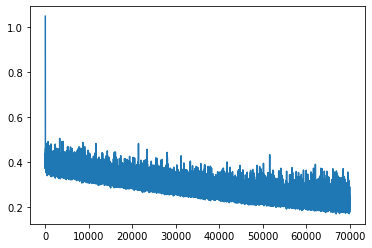

In [11]:
plt.plot(gd_l)


### extracting quantiles

In [12]:
### inverse cdf solve for quantiles
from scipy.interpolate import interp1d

def inverse_g(g_function):
    def find_q_from_g(q,x_in,miny=torch.min(y),maxy=torch.max(y)):
        g_function.eval()
        poss_vals=4000
        with torch.no_grad():
            x_in = x_in.to(device)
            y_poss=torch.linspace(-2.,3.,poss_vals).reshape(-1,1)
            probs=torch.sigmoid(g_function(y_poss.to(device),x_in.repeat(poss_vals,1).to(device)))
        cdf=interp1d(probs.cpu().numpy().ravel(),y_poss.cpu().numpy().ravel()) 
        return cdf(q)
    return find_q_from_g



In [13]:
interp_points=100
x_interp_CN_g=torch.linspace(-.5,.5,interp_points)

find_q_from_g=inverse_g(gd)
y_interp_CN_g=np.zeros((interp_points,3))
for i in notebook.trange(interp_points):
    y_interp_CN_g[i,:]=find_q_from_g([0.25,0.5,0.75],x_interp_CN_g[i])
 
gdout=y_interp_CN_g

## caculating the truth

In [15]:
dt=np.load(r'/content/drive/My Drive/overfit_discover/xymusd.npy')
med=dt[:,2].ravel()
std=dt[:,3].ravel()
up=med+stats.norm.ppf(0.75)*std
low=med+stats.norm.ppf(0.25)*std

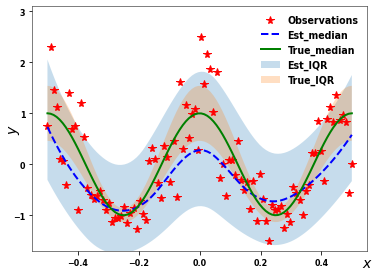

In [16]:

fig = plt.gcf()
fig.set_size_inches(6,4.5)


plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 0


plt.rcParams['axes.linewidth'] = 0.5



plt.rcParams['axes.labelsize'] = 10

plt.rcParams['axes.titlesize'] = 10

plt.rcParams['xtick.labelsize'] = 8

plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 9.5
plt.plot(x,y,'*',ms=8,color='red')
plt.plot(x_interp_CN_g,y_interp_CN_g[:,1],'--',color='blue',lw=2)
plt.plot(x,med,color='green',lw=2)
plt.fill_between(x_interp_CN_g.detach().numpy().ravel(), y_interp_CN_g[:,0], y_interp_CN_g[:,2],alpha=.25)
plt.fill_between(x.detach().numpy().ravel(), low, up,alpha=.25)
plt.legend(['Observations','Est_median','True_median','Est_IQR','True_IQR'],frameon=False)
plt.xlabel('$x$',fontsize=14)
plt.gca().xaxis.set_label_coords(1.0, -0.02)
plt.ylabel('$y$',fontsize=14)
plt.gca().yaxis.set_label_coords(-0.03, 0.5)

plt.ylim([-1.7,3.1])
plt.xlim([-0.55,0.55])
fig.savefig(r'/content/drive/My Drive/overfit_discover/dist_gd.pdf',transparent=True,bbox_inches = 'tight',
    pad_inches = 0.2)